# Punto 1
## Implementaciones con FFT:


Librerías y definición de parámetros

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
import time 
import mpmath as mp

In [2]:
#Definición de unidades
    #Escalas
um=1e-6
mm=1e-3
nm=1e-9
    #Tamaño imagen
N=200
M=200
    #longitud de onda
w_length=633*nm
    #Tamaño de pixel
dx=dy=1*um #equivalencia con el mundo físico

Abertura de prueba para las implementaciones con FFT

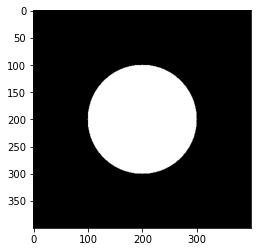

In [3]:
M=400
x = np.arange(-M/2,M/2, 1)
y = np.arange(-M/2,M/2, 1)
fx=x*dx
fy=y*dy
xx, yy = np.meshgrid(fx, fy)
rad=100*um

disco5=np.array(xx**2+yy**2<=rad**2,dtype=bool)
mask2=disco5
plt.gray()
plt.imshow(mask2, cmap='gray')

### - Espectro Angular

In [4]:
def A_apx(U_f,dx_f,dy_f,z_f,wave_length):
    U_freq=np.fft.fftshift(np.fft.fft2(U_f))
    
    N_f,M_f=np.shape(U_f) #Da el número de elementos en cada dimensión de U_f
    x=np.arange(-int(M_f/2),int(M_f/2),1) #arreglo desde -la mitad del número de elementos que tenga cada dimensión
    y=np.arange(-int(N_f/2),int(N_f/2),1) #hasta la mitad de número de elementos en cada dimensión, con pasos de a 1.
    X,Y=np.meshgrid(x,y) #Retorna matrices coordenadas de vectores coordenados
    
     #dimensionando
    fX=X*(1/(M_f*dx_f)) 
    fY=Y*(1/(N_f*dy_f))
    
    k= 2*np.pi/wave_length
    C1 = 1j*z_f*k

    matriz = np.exp(C1*np.sqrt(1-(wave_length**2)*((fX**2)+(fY**2))))

    freq_p = U_freq*matriz
    
    return freq_p

Resultado

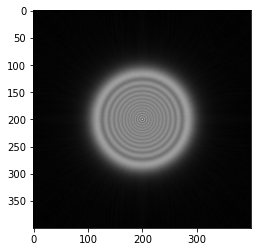

In [5]:
z2=632*um
A_prop=A_apx(mask2,dx,dy,z2,w_length)
ab_prop=np.fft.ifft2(A_prop)

plt.figure()
plt.imshow(
    np.abs(ab_prop)
        )
plt.show()

### -Transformada de Fresnel

In [6]:
def T_fre(U_f,dx_f,dy_f,z_f,wave_length):
    
    k= 2*np.pi/wave_length
    N_f,M_f=np.shape(U_f) 
    x=np.arange(-int(M_f/2),int(M_f/2),1) 
    y=np.arange(-int(N_f/2),int(N_f/2),1) 
    X,Y=np.meshgrid(x,y) 
    
     #dimensionando
    fX=X*(dx_f) 
    fY=Y*(dy_f)
    U_prima=(U_f*np.exp((-1j*k/(2*z_f))*((fX**2)+(fY**2)))) #U'
    U_dprima=np.fft.fftshift(np.fft.fft2(U_prima*dx_f**2)) #U''
    
    C1=np.exp(1j*k*z_f)/(1j*wave_length*z_f) #e^(ikz)/ilambda z
    C2=(1j*k)/(2*z_f)#ik/2 z
    
    fXs=X*(wave_length*z_f/(N_f*dx_f))
    fYs=Y*(wave_length*z_f/(M_f*dy_f))
    
    U_sal=C1*np.exp(C2*(fXs**2+fYs**2))*U_dprima

    return U_sal

Resultado

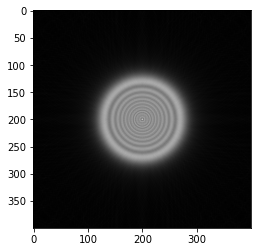

In [7]:
z2=742*um
T_prop=T_fre(mask2,dx,dy,z2,w_length)

plt.figure()
plt.imshow( 
    np.abs(T_prop)
        )
plt.show()

## Implementación con DFT y Comparación

Abertura de prueba para las implementaciones con DFT y la comparación

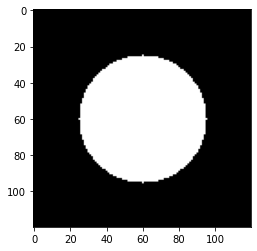

In [8]:
M=120
x = np.arange(-M/2,M/2, 1)
y = np.arange(-M/2,M/2, 1)
fx=x*dx
fy=y*dy
xx, yy = np.meshgrid(fx, fy)
rad=35*um

disco5=np.array(xx**2+yy**2<=rad**2,dtype=bool)
mask2=disco5
plt.gray()
plt.imshow(mask2, cmap='gray')

Función DFT

In [9]:
def DFT(mat): #este es que funciona
    M,N= len(mat), len(mat[0]) #Captura el tamano de mat
    F = [([0]*N) for i in range(M)] #Crea una matriz de zeros de igual tamano que mat
    for fila in range(0,M): #Correr  por las filas de salida
        for ele in range(0,N): #Correr por las columnas de salida
            H= [([0]*N) for i in range(M)] 
            for m in range(0,M): #Correr por las filas de la entrada
                for n in range(0,N): #Correr por las columnas de la entrada
                    H[m][n]= mat[m][n] * np.exp(-2* 1j * np.pi *  (fila * m / M + ele * n / N) ) #Multiplicar por kernel
            F[fila][ele]=np.sum(H) #Sumar la salida de un pixel
            Z = np.array(F, dtype=complex) #Convertir a array de numpy
    return Z

Función DFTI

In [10]:
def DFTI(mat): #este es que funciona
    M,N= len(mat), len(mat[0]) #Captura el tamano de mat
    F = [([0]*N) for i in range(M)] #Crea una matriz de zeros de igual tamano que mat
    for fila in range(0,M): #Correr  por las filas de salida
        for ele in range(0,N): #Correr por las columnas de salida
            H= [([0]*N) for i in range(M)] 
            for m in range(0,M): #Correr por las filas de la entrada
                for n in range(0,N): #Correr por las columnas de la entrada
                    H[m][n]= mat[m][n] * np.exp(2* 1j * np.pi *  (fila * m / M + ele * n / N) ) #Multiplicar por kernel
            F[fila][ele]=np.sum(H) #Sumar la salida de un pixel
            Z = np.array(F, dtype=complex) #Convertir a array de numpy
    return Z

### - Espectro Angular

Función Espectro Angular con DFT

In [11]:
def AS_DFT(U_f,dx_f,dy_f,z_f,wave_length):
    U_freq=np.fft.fftshift(DFT(U_f))

    
    N_f,M_f=np.shape(U_f) 
    x=np.arange(-int(M_f/2),int(M_f/2),1) 
    y=np.arange(-int(N_f/2),int(N_f/2),1) 
    X,Y=np.meshgrid(x,y) 
    
     #dimensionando
    fX=X*(1/(M_f*dx_f)) 
    fY=Y*(1/(N_f*dy_f))
    
    k= 2*np.pi/wave_length
    C1 = 1j*z_f*k

    matriz = np.exp(C1*np.sqrt(1-(wave_length**2)*((fX**2)+(fY**2))))

    freq_p = U_freq*matriz
 
    return freq_p

#### Comparación Espectro Angular

Con la función de Espectro Angular con FFT

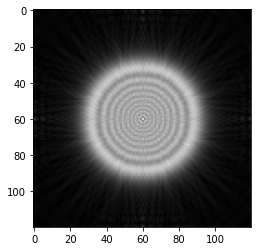

0.1249239444732666


In [12]:
inicio = time.time()
z2 = 100*um
f_prop = A_apx(mask2,dx,dy,z2,w_length)
fin=np.fft.ifft2(f_prop)
plt.figure()
plt.imshow((np.abs(fin)))
plt.show()
final = time.time()
print(final-inicio)

Con la función de Espectro Angular con DFT

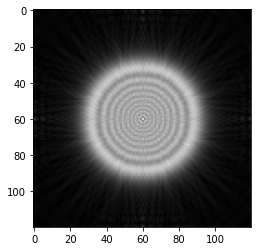

961.9387645721436


In [13]:
inicio2 = time.time()
z2 = 100*um
f_prop = AS_DFT(mask2,dx,dy,z2,w_length)
fin=DFTI(f_prop)
plt.figure()
plt.imshow((np.abs(fin)))
plt.show()
final2 = time.time()
print(final2-inicio2)

### - Transformada de Fresnel

Función Transformada de Fresnel con DFT

In [14]:
def T_fre_DFT(U_f,dx_f,dy_f,z_f,wave_length):
    
    k= 2*np.pi/wave_length
    N_f,M_f=np.shape(U_f) 
    x=np.arange(-int(M_f/2),int(M_f/2),1) 
    y=np.arange(-int(N_f/2),int(N_f/2),1) 
    X,Y=np.meshgrid(x,y) 
    
     #dimensionando
    fX=X*(dx_f) 
    fY=Y*(dy_f)
    U_prima=(U_f*np.exp((-1j*k/(2*z_f))*((fX**2)+(fY**2)))) #U'
    U_dprima=np.fft.fftshift(DFT(U_prima*dx_f**2)) #U''
    
    C1=np.exp(1j*k*z_f)/(1j*wave_length*z_f) #e^(ikz)/ilambda z
    C2=(1j*k)/(2*z_f)#ik/2 z
    
    fXs=X*(wave_length*z_f/(N_f*dx_f))
    fYs=Y*(wave_length*z_f/(M_f*dy_f))
    
    U_sal=C1*np.exp(C2*(fXs**2+fYs**2))*U_dprima
    
    return U_sal

#### Comparación con Transformada de Fresnel

Con la función de la Transformada de Fresnel con FFT

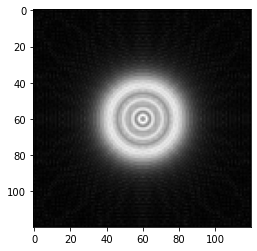

0.10016679763793945


In [15]:
inicio = time.time()
z2=250*um
T_prop=T_fre(mask2,dx,dy,z2,w_length)

plt.figure()
plt.imshow( 
    np.abs(T_prop)
        )
plt.show()
final = time.time()
print(final-inicio)

Con la función de la transformada de Fresnel con DFT

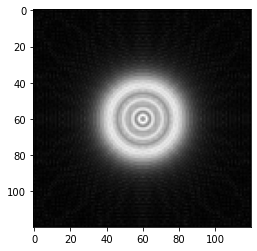

273.87264490127563


In [16]:
inicio2 = time.time()
z2 = 250*um
f_prop = T_fre_DFT(mask2,dx,dy,z2,w_length)
plt.figure()
plt.imshow((np.abs(f_prop)))
plt.show()
final2 = time.time()
print(final2-inicio2)

# Punto 2

## a) Efecto Talbot

Implementación utilizada

1.0


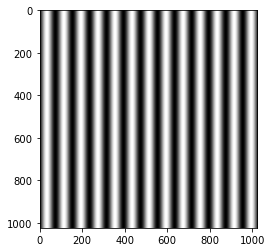

(1024, 1024)

In [11]:
#Tamaño del [p0]ixel en el plano de entrada
p0=1*um ##Ajustar a unidades
# Factor de contraste 0<=m<=1 
m=1
#hacer rejilla
## Auxiliar ## 
P=1024
x = np.arange(-P*p0/2, P*p0/2, p0) ## P es el numero de pixeles
y = np.arange(-P*p0/2, P*p0/2, p0)
xx, yy = np.meshgrid(x, y, sparse=True)
#Dibujar rejilla 1D
L=80*um ## Ajustar a unidades 

rejilla_1D = 1/2*(1+m*np.cos(2*np.pi*xx/L+0*yy)) 

print(np.max(rejilla_1D))
plt.imshow(rejilla_1D, cmap='gray',vmin=0,vmax=1)
plt.show()
np.shape(rejilla_1D)

 Formación de autoimagen positiva

0.02025316455696202


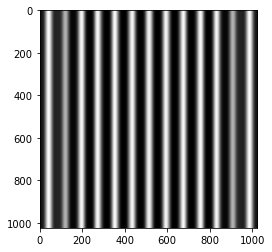

In [15]:
w_lentgth=632*nm ##longitud de onda 
N=2 ## valor N par

## calcular la distancia de talbot
Z2=N*((L**2)/w_lentgth)
print (Z2)
f_prop= A_apx(rejilla_1D,dx,dy,Z2,w_length) ## propagación por espectro angular
fin=np.fft.ifft2(f_prop)
fin2=(np.abs(fin))**2

## Mostrar autoimagen
plt.imshow(fin2, cmap='gray',vmin=0,vmax=1.044)
plt.show()

Formación de autoimagen negativa

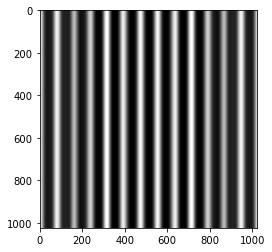

In [14]:
w_lentgth=632*nm ##longitud de onda 
N=3 ## valor N impar

## calcular la distancia de talbot
Z2=N*((L**2)/w_lentgth)
f_prop= A_apx(rejilla_1D,dx,dy,Z2,w_length) ## propagación por espectro angular
fin=np.fft.ifft2(f_prop)
fin2=(np.abs(fin))**2

## Mostrar autoimagen
plt.imshow(fin2, cmap='gray',vmin=0,vmax=1.044)
plt.show()

## b) Principio de Babinet


Abertura de comparación

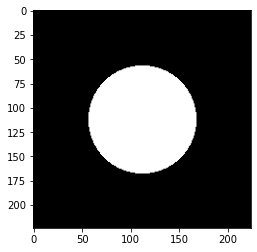

In [20]:
x = np.arange(-224/2,224/2, 1)
y = np.arange(-224/2,224/2, 1)
fx=x*dx
fy=y*dy
xx, yy = np.meshgrid(fx, fy)
rad=55.5*um #esto para obtener 24 zonas de fresnel al propagar 200um

disco5=np.array(xx**2+yy**2<=rad**2,dtype=bool) 
disco5=disco5
plt.gray()
plt.imshow(disco5, cmap='gray') 

Propagación de la abertura con Espectro Angular

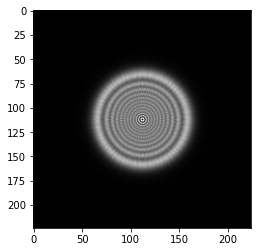

In [21]:
z2 = 200*um
f_prop = A_apx(disco5,dx,dy,z2,w_length)
fin2=np.fft.ifft2(f_prop)
finint=np.abs(fin2)**2

plt.figure()
plt.imshow((np.abs(finint)))
plt.show()

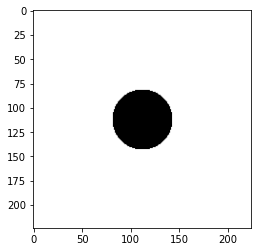

In [22]:
M=224
x = np.arange(-M/2,M/2, 1)
y = np.arange(-M/2,M/2, 1)

fx=x*dx
fy=y*dy
xx, yy = np.meshgrid(fx, fy)
radio=31*um #puede tener cualquier radio

disco4=np.array(xx**2+yy**2>=radio**2,dtype=bool)
disco4=(disco4)

plt.gray()
plt.imshow(disco4, cmap='gray')

Transmitancia como anillo (dona)

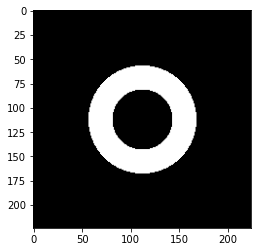

In [23]:
dona=disco5*disco4
plt.gray()
plt.imshow(dona, cmap='gray')

Propación de la dona con Espectro Angular

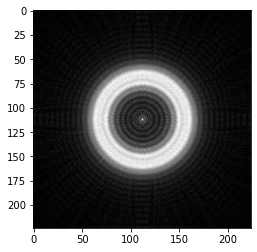

In [24]:
z2 = 200*um
f_prop = A_apx(dona,dx,dy,z2,w_length)
dona_prop=np.fft.ifft2(f_prop)
plt.figure()
plt.imshow((np.abs(dona_prop)))
plt.show()

Abertura complementaria al obstáculo puesto

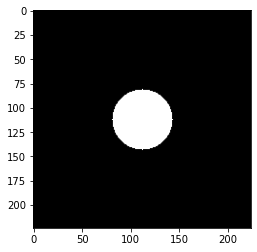

In [25]:
M=224
x = np.arange(-M/2,M/2, 1)
y = np.arange(-M/2,M/2, 1)
fx=x*dx
fy=y*dy
xx, yy = np.meshgrid(fx, fy)
radio=31*um # igual que el obstáculo central

disco3=np.array(xx**2+yy**2<=radio**2,dtype=bool)
disco3=disco3
plt.gray()
plt.imshow(disco3, cmap='gray')

Propagación de la abertura previa con Espectro Angular

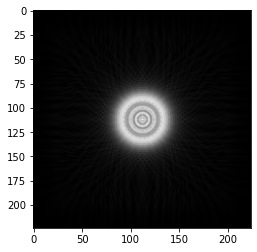

In [26]:
z2 = 200*um
f_prop = A_apx(disco3,dx,dy,z2,w_length)
obsc_prop=np.fft.ifft2(f_prop)
plt.figure()
plt.imshow((np.abs(obsc_prop)))
plt.show()

Aplicación del principio de Babitet sumando la propagación de la abertura previa y la dona

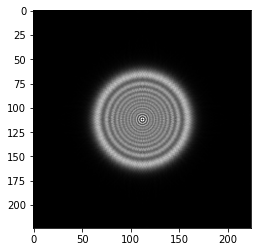

In [27]:
sup=obsc_prop+dona_prop
supint=np.abs(sup)**2
plt.figure()
plt.imshow(np.abs(supint))
plt.show()

Verificación de la similitud entre la abertura inicial de comparación y la resultante sumando la dona y la abertura pequeña

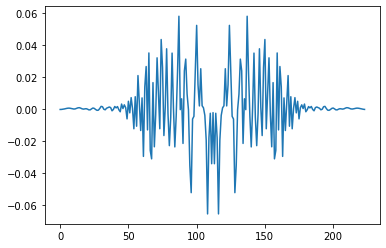

In [28]:
plt.figure()
plt.plot(np.abs(supint[112,:])-np.abs(finint[112,:]))
plt.show()

### Haciendo la misma propagación pero con Transformada de Fresnel

(Se utilizan las mismas aberturas y obstáculos que en el espectro angular)

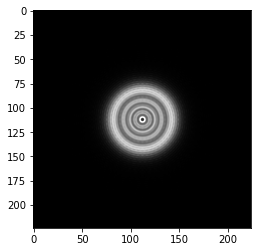

In [29]:
#Como se cambia la distancia el número de zonas cambia
z2=480*um  #10 zonas de Fresnel
T_prop=T_fre(disco5,dx,dy,z2,w_length)
finint2=np.abs(T_prop)**2
plt.figure()
plt.imshow((np.abs(finint2)))
plt.show()

Dona propagada con Transformada de Fresnel

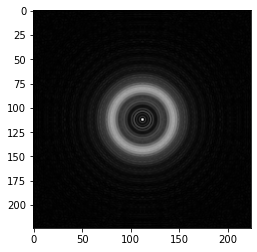

In [30]:
z2=480*um
T_prop=T_fre(dona,dx,dy,z2,w_length)
dona_prop=T_prop
plt.figure()
plt.imshow((np.abs(dona_prop)))
plt.show()

Abertura pequeña propagada con Transformada de Fresnel

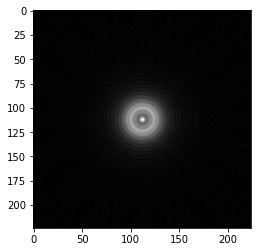

In [31]:
z2=480*um
T_prop=T_fre(disco3,dx,dy,z2,w_length)
obsc_prop=T_prop
plt.figure()
plt.imshow((np.abs(obsc_prop)))
plt.show()

Aplicación del principio de Babitet sumando las propagaciones realizadas con Transformada de Fresnel

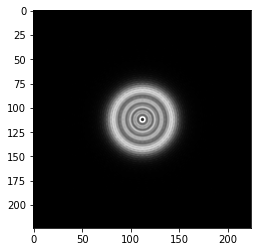

In [32]:
sup=obsc_prop+dona_prop
supint=np.abs(sup)**2
plt.figure()
plt.imshow(np.abs(supint))
plt.show()

Verificación de la similitud entre la abertura inicial de comparación y la resultante sumando la dona y la abertura pequeña

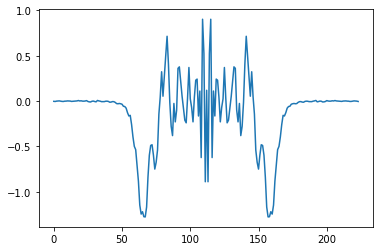

In [33]:
plt.figure()
plt.plot(np.abs(supint[112,:])-np.abs(finint[112,:]))
plt.show()

## c) Experimento de Arago

Para tener control del obstáculo centrar mediante zonas de fresnel se utiliza el principio de Babinet tomando las contribuciones de las dos siguientes aberturas restándolas.

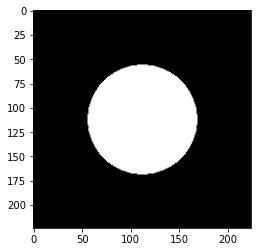

In [34]:
x = np.arange(-224/2,224/2, 1)
y = np.arange(-224/2,224/2, 1)
fx=x*dx
fy=y*dy
xx, yy = np.meshgrid(fx, fy)
rad=56.3*um #esto para obtener 25 zonas de fresnel si se propaga 200um y 9 si se propaga 550um

disco5=np.array(xx**2+yy**2<=rad**2,dtype=bool) 
disco5=disco5
plt.gray()
plt.imshow(disco5, cmap='gray') 

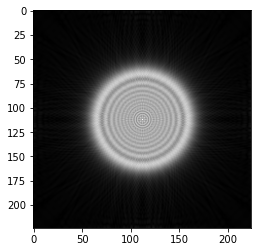

In [35]:
z2 = 200*um
f_prop = A_apx(disco5,dx,dy,z2,w_length)
obsc_prop5=np.fft.ifft2(f_prop)
plt.figure()
plt.imshow((np.abs(obsc_prop5)))
plt.show()

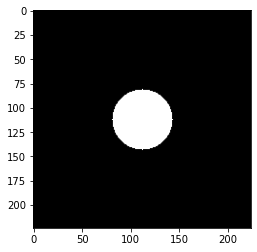

In [36]:
M=224
x = np.arange(-M/2,M/2, 1)
y = np.arange(-M/2,M/2, 1)
fx=x*dx
fy=y*dy
xx, yy = np.meshgrid(fx, fy)
radio=31*um #para obtener 7 zonas de fresnel si se propaga 200 um y 3 si se propaga 550um

disco3=np.array(xx**2+yy**2<=radio**2,dtype=bool)
disco3=disco3
plt.gray()
plt.imshow(disco3, cmap='gray')

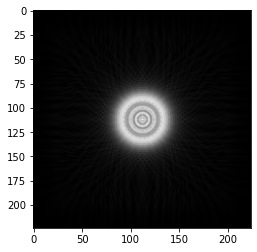

In [37]:
z2 = 200*um
f_prop = A_apx(disco3,dx,dy,z2,w_length)
obsc_prop3=np.fft.ifft2(f_prop)
plt.figure()
plt.imshow((np.abs(obsc_prop3)))
plt.show()

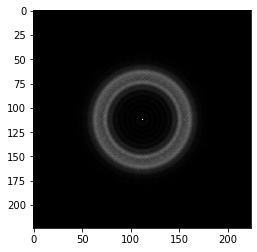

In [38]:
resta=obsc_prop5-obsc_prop3
restaint=np.abs(resta)**2
plt.figure()
plt.imshow(np.abs(restaint))
plt.show()

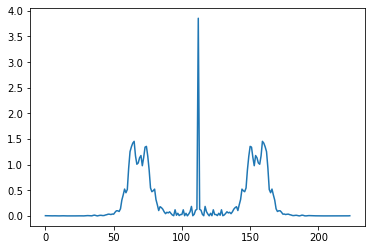

In [39]:
plt.figure()
plt.plot(np.abs(restaint[112,:]))
plt.show()

Con transformada de fresnel (usando las mismas aberturas que para 

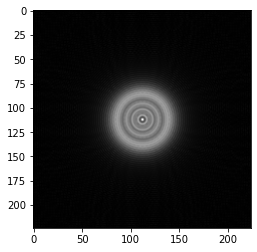

In [40]:
z2=550*um #para 9 zonas de fresnel
T_prop=T_fre(disco5,dx,dy,z2,w_length)
finint2=np.abs(T_prop)
plt.figure()
plt.imshow(finint2)
plt.show()

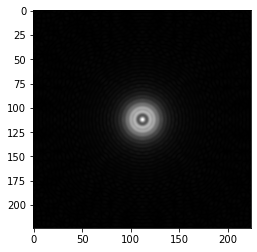

In [41]:
z2=550*um
T_prop=T_fre(disco3,dx,dy,z2,w_length)
obsc_prop=T_prop
plt.figure()
plt.imshow((np.abs(obsc_prop)))
plt.show()

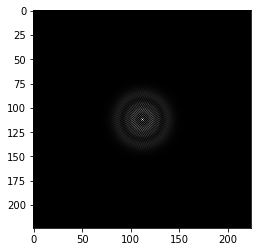

In [42]:
resta=finint2-obsc_prop
restaint=np.abs(resta)**2
plt.figure()
plt.imshow(np.abs(restaint))
plt.show()

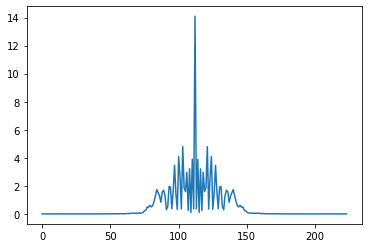

In [43]:
plt.figure()
plt.plot(np.abs(restaint[112,:]))
plt.show()